In [111]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt, cv2
import cuml #, cupy
import timm
import torch
from torch.utils.data import DataLoader, Dataset
import sys
sys.path.append('../')
from src.pl_module import MelanomaModel
from src.transforms.albu import get_valid_transforms
import skimage.io
from tqdm.auto import tqdm
print('RAPIDS version',cuml.__version__)
print('timm version',timm.__version__)
%matplotlib inline

RAPIDS version 0.14.0+0.g31202da.dirty
timm version 0.2.0


In [2]:
class MelanomaDataset(Dataset):
    def __init__(self, df_path, data_path, image_folder, transform=None):
        super().__init__()
        self.image_folder = image_folder
        self.df = pd.read_csv(f"{data_path}/{df_path}.csv")
        self.transform = transform
        self.df.loc[:, 'bin_target'] = (self.df.target >= 0.5).astype(int)
        self.targets = self.df.bin_target.values
        self.target_counts = self.df.bin_target.value_counts().values

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_name
        img_path = f"{self.image_folder}/{img_id}.jpg"
        image = skimage.io.imread(img_path)
        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = image.transpose(2, 0, 1)
        image = torch.from_numpy(image)
        label = row.target
        # target = onehot(2, label)
        target = torch.tensor(np.expand_dims(label, 0)).float()
        return{'features': image, 'target': target}

In [3]:
# GAN generated data

In [4]:
model = MelanomaModel.net_mapping('resnest50d', 'SingleHeadMax')
model.load_state_dict(torch.load('../weights/train_384_balancedW_resnest50d_fold0_heavyaugs_averaged_best_weights.pth'))
model.cuda()
model.eval()

ClassificationSingleHeadMax(
  (enc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [79]:
gan_generated_data_dataset = MelanomaDataset(
    df_path='generated_data_v.003.cleaned', 
    data_path='../data', 
    image_folder='../data/generated_data_v.003//', 
    transform=get_valid_transforms())
gan_generated_data_daloader = DataLoader(gan_generated_data_dataset, batch_size=16, num_workers=1)

In [80]:
train_dataset = MelanomaDataset(
    df_path='train', 
    data_path='../data/', 
    image_folder='../data/jpeg-melanoma-384x384/train/', 
    transform=get_valid_transforms())
train_daloader = DataLoader(train_dataset, batch_size=16, num_workers=1)

In [122]:
external_dataset = MelanomaDataset(
    df_path='external_train', 
    data_path='../data/', 
    image_folder='../data/jpeg-isic2019-384x384/train/', 
    transform=get_valid_transforms())
external_dataloader = DataLoader(external_dataset, batch_size=16, num_workers=1)

In [81]:
features_gan = []
for batch in tqdm(gan_generated_data_daloader, total=len(gan_generated_data_daloader)):
    with torch.no_grad():
        features_gan.extend(model.get_features(batch['features'].cuda()).cpu().numpy())

In [82]:
features_train = []
for batch in tqdm(train_daloader, total=len(train_daloader)):
    with torch.no_grad():
        features_train.extend(model.get_features(batch['features'].cuda()).cpu().numpy())

In [124]:
features_external = []
for batch in tqdm(external_dataloader, total=len(external_dataloader)):
    with torch.no_grad():
        features_external.extend(model.get_features(batch['features'].cuda()).cpu().numpy())

In [132]:
tsne_cuml_model = cuml.TSNE(perplexity=250.0, n_neighbors=150)

In [135]:
all_features = np.stack(features_train + features_gan + features_external)
targets = np.concatenate([
    gan_generated_data_dataset.df.target.values, 
    train_dataset.df.target.values,
    external_dataset.df.target.values])
sample_origin = np.array(
    ['gan'] * len(gan_generated_data_dataset.df.target.values) +\
    ['train'] * len(train_dataset.df.target.values) +\
    ['external'] * len(external_dataset.df.target.values)
)

In [136]:
embed2Dn = tsne_cuml_model.fit_transform(all_features)

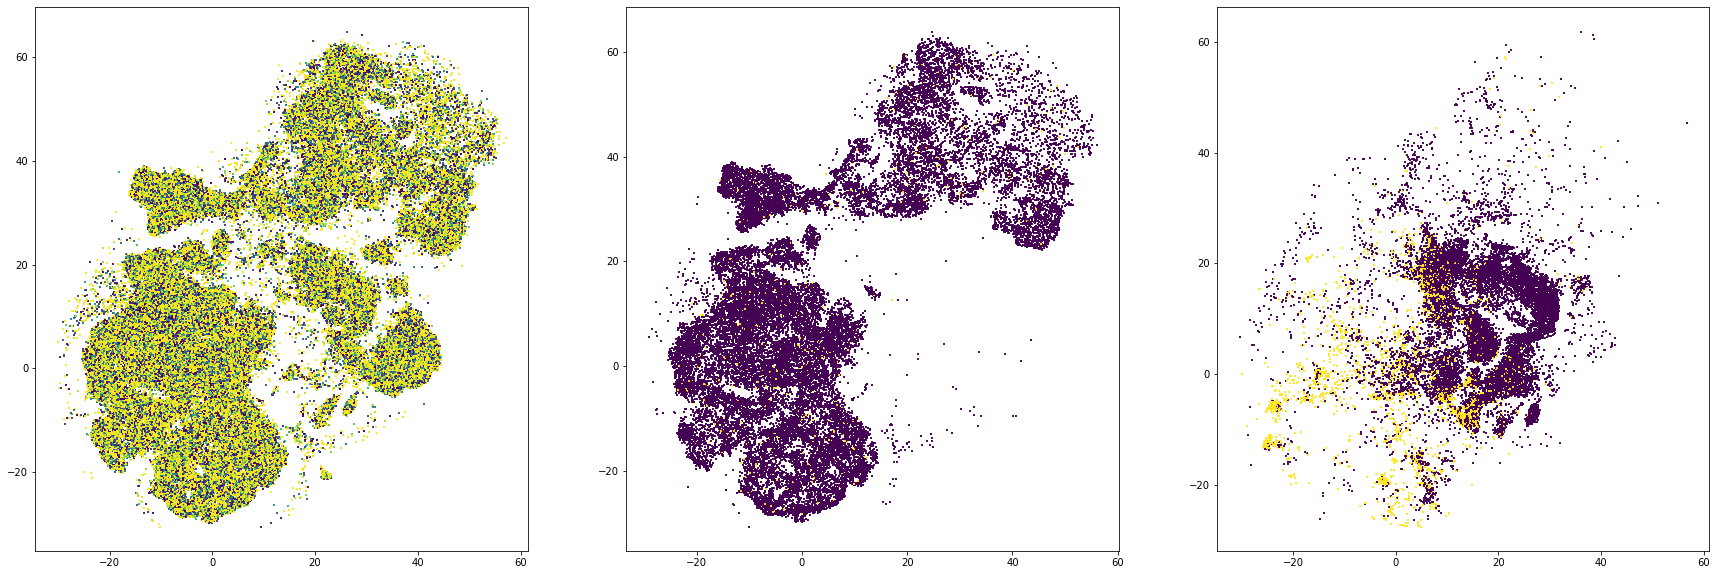

In [145]:
f, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].scatter(
    embed2Dn[np.where(sample_origin == 'gan')[0], 0], 
    embed2Dn[np.where(sample_origin == 'gan')[0], 1], 
    c=targets[np.where(sample_origin == 'gan')[0]],
    s=1.0, 
    marker='s')
ax[1].scatter(
    embed2Dn[np.where(sample_origin == 'train')[0], 0], 
    embed2Dn[np.where(sample_origin == 'train')[0], 1], 
    c=targets[np.where(sample_origin == 'train')[0]],
    s=1.0, 
    marker='s')
ax[2].scatter(
    embed2Dn[np.where(sample_origin == 'external')[0], 0], 
    embed2Dn[np.where(sample_origin == 'external')[0], 1], 
    c=targets[np.where(sample_origin == 'external')[0]],
    s=1.0, 
    marker='s')

In [147]:
CLUSTERS = 20
model_kmeans = cuml.KMeans(n_clusters=CLUSTERS)
model_kmeans.fit(all_features)

KMeans(handle=<cuml.common.handle.Handle object at 0x7f907847f870>, n_clusters=20, max_iter=300, tol=0.0001, verbose=2, random_state=1, init='scalable-k-means++', n_init=1, oversampling_factor=2.0, max_samples_per_batch=32768, output_type='numpy')

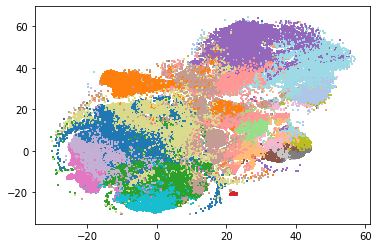

In [152]:
plt.scatter(
    embed2Dn[:, 0], 
    embed2Dn[:, 1], 
    c=model_kmeans.labels_,
    s=1.0, 
    cmap='tab20',
    marker='s')